In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.linalg import eigh
from scipy.linalg import null_space
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import curve_fit
from scipy.integrate import simps 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.widgets import Slider

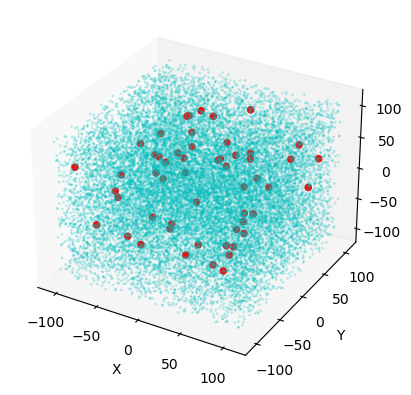

(19974, 3)


In [28]:
a = 3.57
size = 30
prob_C=1.1e-2
prob_e=30e-6
    
# Total number of unit cells
grid_range = np.arange(-size, size + 1)
Ncells = len(grid_range) ** 3
Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

# How many atoms to sample
num_C = int(Natoms * prob_C)
num_e = int(Natoms * prob_e)
total_specials = num_C + num_e

# Sample linear indices (0 to Natoms-1)
indices = np.random.choice(Natoms, total_specials, replace=False)
carbon_indices = np.random.choice(indices, num_C, replace=False)
electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

# Convert linear index to (unit cell index, basis atom index)
unit_index = indices // 8
basis_index = indices % 8

# Map unit index back to (l, m, n) grid coordinates
n_grid = len(grid_range)
L = unit_index // (n_grid ** 2)
M = (unit_index // n_grid) % n_grid
N = unit_index % n_grid
L = L + grid_range[0]
M = M + grid_range[0]
N = N + grid_range[0]

# FCC + offset basis
basis = (a/2)*np.array([
    [0, 0, 0],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [0.5, 0.5, 0.5],
    [1.5, 1.5, 0.5],
    [1.5, 0.5, 1.5],
    [0.5, 1.5, 1.5],
])

# Construct positions
unit_coords = np.stack([L, M, N], axis=1) * a
special_positions = unit_coords + basis[basis_index]

# Split into carbon and electron positions
carbon_pts = special_positions[np.isin(indices, carbon_indices)]
e_pts = special_positions[np.isin(indices, electron_indices)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

print(carbon_pts.shape)

In [29]:
#mean nearest neighbor carbon distance
all_carbon_distances = cdist(carbon_pts,carbon_pts)
np.fill_diagonal(all_carbon_distances, np.inf)
nn_carbon_distance = np.min(all_carbon_distances, axis=1)
average_nn_carbon = np.mean(nn_carbon_distance)
print(average_nn_carbon, 'angstroms')

4.540933006337611 angstroms


In [26]:
#mean nearest neighbor electron distance
all_electron_distances = cdist(e_pts,e_pts)
np.fill_diagonal(all_electron_distances, np.inf)
nn_electron_distance = np.min(all_electron_distances, axis=1)
average_nn_electron = np.mean(nn_electron_distance)
print(average_nn_electron, 'angstroms')

31.48101992699035 angstroms


In [30]:
#CC dipolar coupling with average nearest neighbor distance
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28024.951e6 #Hz/T
r1 = average_nn_carbon*1e-10
D_CC = 2*np.pi*(mu_0*gamma_C*gamma_C*hbar)/(4*np.pi*(r1**3))
print(D_CC, 'Hz')

81.13831605509662 Hz


In [15]:
#ee dipolar coupling with average nearest neighbor distance
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28.024951e9 #Hz/T
r2 = average_nn_electron*1e-10
D_ee = 2*np.pi*(mu_0*gamma_e*gamma_e*hbar)/(4*np.pi*(r2**3))
print(D_ee*1e-6, 'MHz')

0.4441621312905941 MHz


In [16]:
#Calculate spin diffusion barrier radius based on Khutsishvili equation
k_B = 1.38e-23
S = np.tanh((2*np.pi*gamma_e*hbar*9.4)/(2*k_B*100))
r3 = (average_nn_carbon*1e-10)*(S*(gamma_e/gamma_C))**(1/4)
print(r3*1e10, 'angstroms')

16.50913019787546 angstroms


In [17]:
# excitation BW = 25kHz
# Readout BW = 250kHz

# D_ij = 125e3
# r4 = ((mu_0*gamma_e*gamma_C*hbar)/(2*D_ij))**(1/3)
# print(r4*1e10, 'angstroms')

r4 = 7*1e-10
D_ij = (mu_0*gamma_e*gamma_C*hbar)/(2*(r4**3))
print(D_ij*1e-3, 'kHz')

57.96788173439546 kHz


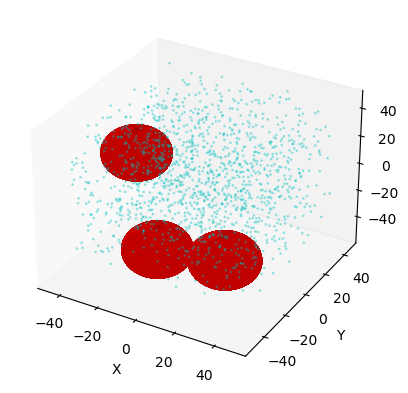

In [18]:
# Define the radius of the spheres
radius = r3*1e10

# Create a meshgrid for the sphere
resolution = 30
u = np.linspace(0, 2 * np.pi, resolution)
v = np.linspace(0, np.pi, resolution)
u, v = np.meshgrid(u, v)

# Parametric equations for the sphere
x_sphere = radius * np.outer(np.cos(u), np.sin(v))
y_sphere = radius * np.outer(np.sin(u), np.sin(v))
z_sphere = radius * np.outer(np.ones(np.size(u)), np.cos(v))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.3, s=1)
# Plot spheres around each point
for pos in range(e_pts.shape[0]):
    ax.plot_surface(e_pts[pos][0] + x_sphere, e_pts[pos][1] + y_sphere, e_pts[pos][2] + z_sphere, color='red', alpha=1)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [19]:
#Calculate the distance between each carbon and the nearest electron and then see if that distance is less than r3
r3 = 16*1e-10

if e_pts.shape[0] == 0:
    # No electron points; all carbon atoms are considered "outside"
    outside_pts = carbon_pts
    inside_pts = np.empty((0, 3))
else:
    diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    min_distances = np.min(distances, axis=1)

    inside_pts = carbon_pts[min_distances < r3*1e10]
    outside_pts = carbon_pts[min_distances >= r3*1e10]

In [20]:
N_carbon = carbon_pts.shape[0]
N_e = e_pts.shape[0]
N_bulk = outside_pts.shape[0]
N_core = inside_pts.shape[0]

In [21]:
print(N_bulk)

1287


In [22]:
print((N_core/N_carbon)*100, '% of carbon inside barrier')

6.4 % of carbon inside barrier


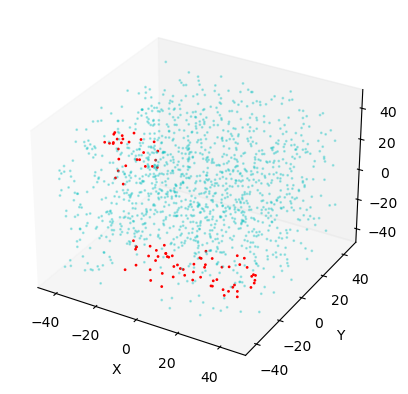

In [23]:
#carbons inside the barrier are plotted in red
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inside_pts[:,0], inside_pts[:,1], inside_pts[:,2], color='r', marker='o', alpha = 1, s=1)
ax.scatter(outside_pts[:,0], outside_pts[:,1], outside_pts[:,2], color='c', marker='o', alpha = 0.3, s=1)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [24]:
#Find the carbon closest to the origin
distances = np.sum(outside_pts**2, axis=1)
min_index = np.argmin(distances)
closest_pt = outside_pts[min_index]

print(closest_pt)

[4.4625 0.8925 0.8925]


In [25]:
shifted_pts = outside_pts - np.array(closest_pt)
print(shifted_pts[min_index])

[0. 0. 0.]


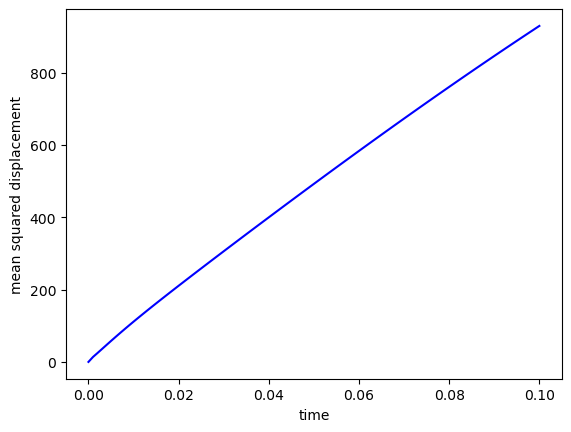

In [23]:
def calculate_mean_squared_distance(alpha, points, time):
    squared_distances = np.sum(points**2, axis=1)
    weighted_squares = alpha[:,time] * squared_distances
    mean_squared_distance = np.sum(weighted_squares)
    return mean_squared_distance
    
D = np.zeros(t_pts)
for t in range(t_pts):
    D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)
    

fig = plt.figure()
plt.plot(T, D, color='b')  
plt.xlabel('time')
plt.ylabel('mean squared displacement')
plt.show()

In [86]:
def get_labels(size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)

    return num_C


concentration = 99e-2
for size in range(1,22):
    num_C = get_labels(size, concentration, 30e-6)
    print(size, 'corresponds to', num_C, 'spins')

1 corresponds to 213 spins
2 corresponds to 990 spins
3 corresponds to 2716 spins
4 corresponds to 5773 spins
5 corresponds to 10541 spins
6 corresponds to 17400 spins
7 corresponds to 26730 spins
8 corresponds to 38910 spins
9 corresponds to 54323 spins
10 corresponds to 73347 spins
11 corresponds to 96362 spins
12 corresponds to 123750 spins
13 corresponds to 155889 spins
14 corresponds to 193160 spins
15 corresponds to 235944 spins
16 corresponds to 284621 spins
17 corresponds to 339570 spins
18 corresponds to 401171 spins
19 corresponds to 469806 spins
20 corresponds to 545854 spins
21 corresponds to 629695 spins


(100, 100)
103.04276251792908


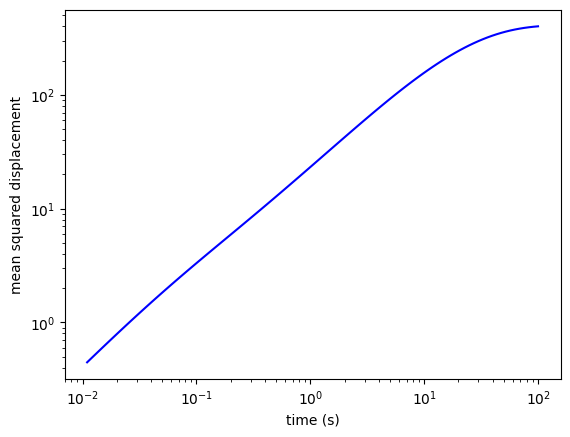

In [6]:
from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    import numpy as np

    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts

    

    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])


    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        if e_pts.shape[0] == 0:
            outside_pts = carbon_pts
            inside_pts = np.empty((0, 3))
        else:
            diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
            distances = np.linalg.norm(diff, axis=2)
            min_distances = np.min(distances, axis=1)

            inside_pts = carbon_pts[min_distances < r3*1e10]
            outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        distances = np.sum(outside_pts**2, axis=1)
        min_index = np.argmin(distances)
        closest_pt = outside_pts[min_index]
        shifted_pts = outside_pts - np.array(closest_pt)
        
        #Calculate W matrix
        box_size = 3.57 * (2*size + 1)

        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC
        return N_bulk, M, shifted_pts, min_index

    
    
    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha



    def calculate_mean_squared_distance(alpha, points, time):
        squared_distances = np.sum(points**2, axis=1)
        weighted_squares = alpha[:,time] * squared_distances
        mean_squared_distance = np.sum(weighted_squares)
        return mean_squared_distance
    
#     tau_p, tau_d = params
    
    size = 5
    t_pts = 100
    T = np.logspace(-2,2,t_pts)
    P = np.zeros(len(T))
    carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 0)
    N_bulk, M, shifted_pts, min_index = calculate_M(size, carbon_pts, e_pts, 1, 2.5e-5)
#     alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha_0 = np.zeros(N_bulk)
    alpha_0[min_index] = 1
    alpha = solve_ode(N_bulk, T, alpha_0, M)
#     P = np.sum(alpha, axis=0)

    D = np.zeros(t_pts)
    for t in range(t_pts):
        D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)
        
    return D


iterations = 100
inputs = [(1)] * iterations

pool = Pool()
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.logspace(-2,2,100)
D_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.loglog(T[1:], D_avg[1:], color='b')
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
plt.show()

# np.savez("MSD_99_500Itr_PBC.npz", time=T, msd=np.array(results))

D = 3.129343740814877 alpha = 0.9008081803280511


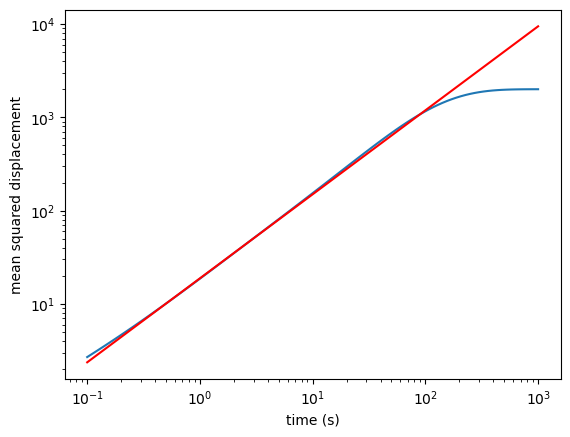

In [19]:
def find_cutoff_index(msd, threshold):
    max_msd = np.max(msd)
    for i in range(len(msd)):
        if msd[i] > threshold * max_msd:
            return i
    return len(msd)

def diffusion_fit(t, alpha, D):
    return 6*D * t**alpha

i_start = 1
i_end = find_cutoff_index(D_avg, 0.03)

time_fit = T[i_start:i_end]
msd_fit = D_avg[i_start:i_end]

popt, pcov = curve_fit(diffusion_fit, time_fit, msd_fit, p0=[1, 1e6])
alpha, D = popt
        
print("D =", D, "alpha =", alpha)
    
plt.figure()
plt.loglog(T, D_avg)
plt.loglog(T, 6*D * T**alpha, color='r')
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
plt.show()

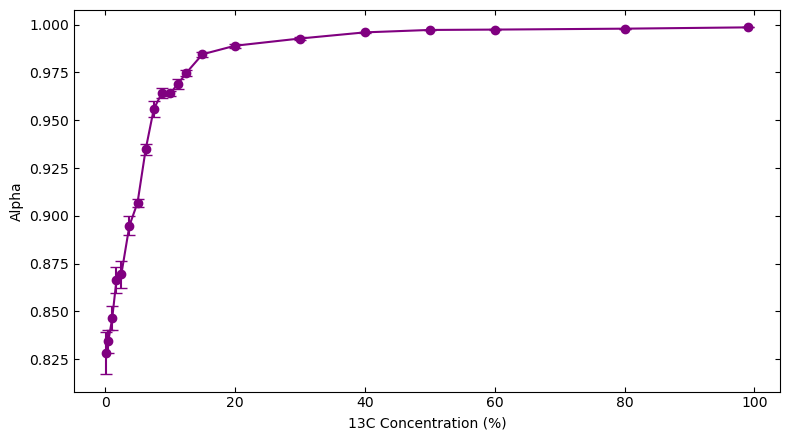

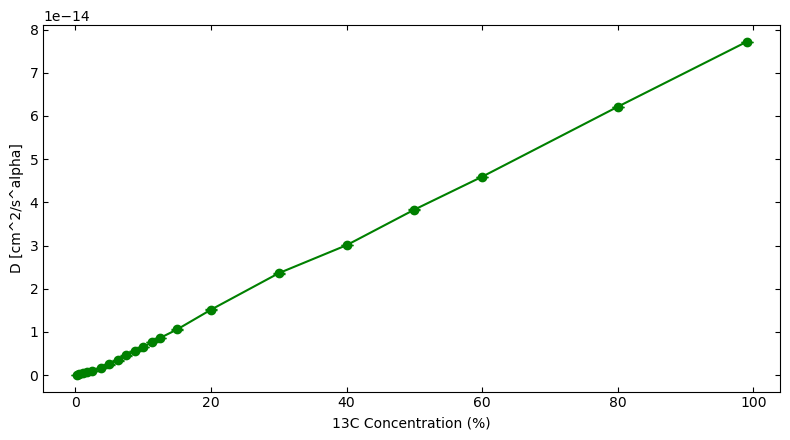

Concentrations: [ 0.2   0.5   1.1   1.75  2.5   3.75  5.    6.25  7.5   8.75 10.   11.25
 12.5  15.   20.   30.   40.   50.   60.   80.   99.  ]
Alpha values: [0.82813216 0.83439571 0.84641455 0.86633236 0.86930337 0.89488734
 0.90687359 0.93470731 0.95584829 0.96427937 0.96403503 0.96913491
 0.97477446 0.98453291 0.98899744 0.99277455 0.99599081 0.99725984
 0.99744529 0.99793214 0.99861288]
D values: [5.34526749e-01 1.60904227e+00 3.86423033e+00 6.39162978e+00
 1.00951956e+01 1.70236678e+01 2.47419477e+01 3.39870953e+01
 4.55056865e+01 5.59753574e+01 6.49380121e+01 7.64216797e+01
 8.62328072e+01 1.05832854e+02 1.51574868e+02 2.36093004e+02
 3.00871488e+02 3.83205057e+02 4.59417684e+02 6.21378740e+02
 7.71622237e+02]
D values in cm^2/s: [5.34526749e-17 1.60904227e-16 3.86423033e-16 6.39162978e-16
 1.00951956e-15 1.70236678e-15 2.47419477e-15 3.39870953e-15
 4.55056865e-15 5.59753574e-15 6.49380121e-15 7.64216797e-15
 8.62328072e-15 1.05832854e-14 1.51574868e-14 2.36093004e-14
 3.008714

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob
import re
import os

def find_cutoff_index(msd, threshold=0.03):
    max_msd = np.max(msd)
    for i in range(len(msd)):
        if msd[i] > threshold * max_msd:
            return i
    return len(msd)

def diffusion_fit(t, alpha, D):
    return 6 * D * t**alpha

# Scan all files matching your pattern
file_list = sorted(glob.glob("MSD_*_500Itr_PBC.npz"))

concentrations = []
alphas_mean = []
alphas_std = []
Ds_mean = []
Ds_std = []

for file in file_list:
    # Extract concentration from filename using regex
    match = re.search(r"MSD_([0-9.]+)_", os.path.basename(file))
    if not match:
        continue
    conc = float(match.group(1))
    
    # Load file
    data = np.load(file)
    T = data["time"]
    results = data["msd"]  # shape: (500, 100)
    
    assert results.shape[0] == 500, f"Expected 500 iterations in {file}, got {results.shape[0]}"
    
    batch_size = 100
    num_batches = 5

    alpha_batch = []
    D_batch = []

    for b in range(num_batches):
        batch = results[b*batch_size:(b+1)*batch_size]
        D_avg = np.mean(batch, axis=0)

        i_start = 1
        i_end = find_cutoff_index(D_avg, threshold=0.03)

        time_fit = T[i_start:i_end]
        msd_fit = D_avg[i_start:i_end]

        try:
            popt, pcov = curve_fit(diffusion_fit, time_fit, msd_fit, p0=[1, 1e6])
            alpha, D = popt
            alpha_batch.append(alpha)
            D_batch.append(D)
        except RuntimeError:
            print(f"Fit failed for batch {b+1} in concentration {conc}")
            alpha_batch.append(np.nan)
            D_batch.append(np.nan)

    # Convert to arrays, drop NaNs
    alpha_batch = np.array(alpha_batch)
    D_batch = np.array(D_batch)

    alpha_batch = alpha_batch[~np.isnan(alpha_batch)]
    D_batch = D_batch[~np.isnan(D_batch)]

    if len(alpha_batch) == 0 or len(D_batch) == 0:
        print(f"Skipping concentration {conc} due to fit failures")
        continue

    concentrations.append(conc)
    alphas_mean.append(np.mean(alpha_batch))
    alphas_std.append(np.std(alpha_batch))
    Ds_mean.append(np.mean(D_batch))
    Ds_std.append(np.std(D_batch))

# Convert to arrays and sort by concentration
concentrations = np.array(concentrations)
alphas_mean = np.array(alphas_mean)
alphas_err = np.array(alphas_std) / np.sqrt(5)
Ds_mean = np.array(Ds_mean)
Ds_err = np.array(Ds_std) / np.sqrt(5)

sort_idx = np.argsort(concentrations)
concentrations = concentrations[sort_idx]
alphas_mean = alphas_mean[sort_idx]
alphas_err = alphas_err[sort_idx]
Ds_mean = Ds_mean[sort_idx]
Ds_err = Ds_err[sort_idx]

# Plot α vs concentration with error bars
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(concentrations, alphas_mean, yerr=alphas_err, fmt='o-', color='purple', capsize=4)
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('13C Concentration (%)')
plt.ylabel('Alpha')
# plt.title('Stretching exponent vs concentration')
# plt.grid(True)
plt.tight_layout()
plt.show()

# Plot D vs concentration with error bars
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(concentrations, 1e-16*Ds_mean, yerr=1e-16*Ds_err, fmt='o-', color='green', capsize=4)
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('13C Concentration (%)')
plt.ylabel('D [cm^2/s^alpha]')
# plt.title('Diffusion coefficient vs concentration')
# plt.grid(True)
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\D.eps", format='eps', dpi=300)

print("Concentrations:", concentrations)
print("Alpha values:", alphas_mean)
print("D values:", Ds_mean)
print("D values in cm^2/s:", Ds_mean * 1e-16)

In [3]:
def get_labels(size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)

    return num_C


concentration = 1.1e-2
for size in range(1,22):
    num_C = get_labels(size, concentration, 30e-6)
    print(size, 'corresponds to', num_C, 'spins')

1 corresponds to 2 spins
2 corresponds to 11 spins
3 corresponds to 30 spins
4 corresponds to 64 spins
5 corresponds to 117 spins
6 corresponds to 193 spins
7 corresponds to 297 spins
8 corresponds to 432 spins
9 corresponds to 603 spins
10 corresponds to 814 spins
11 corresponds to 1070 spins
12 corresponds to 1375 spins
13 corresponds to 1732 spins
14 corresponds to 2146 spins
15 corresponds to 2621 spins
16 corresponds to 3162 spins
17 corresponds to 3773 spins
18 corresponds to 4457 spins
19 corresponds to 5220 spins
20 corresponds to 6065 spins
21 corresponds to 6996 spins


In [13]:
# Finite size scaling analysis
from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    import numpy as np

    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts

    

    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])


    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        if e_pts.shape[0] == 0:
            outside_pts = carbon_pts
            inside_pts = np.empty((0, 3))
        else:
            diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
            distances = np.linalg.norm(diff, axis=2)
            min_distances = np.min(distances, axis=1)

            inside_pts = carbon_pts[min_distances < r3*1e10]
            outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        distances = np.sum(outside_pts**2, axis=1)
        min_index = np.argmin(distances)
        closest_pt = outside_pts[min_index]
        shifted_pts = outside_pts - np.array(closest_pt)
        
        #Calculate W matrix
        box_size = 3.57 * (2*size + 1)

        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC
        return N_bulk, M, shifted_pts, min_index

    
    
    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha



    def calculate_mean_squared_distance(alpha, points, time):
        squared_distances = np.sum(points**2, axis=1)
        weighted_squares = alpha[:,time] * squared_distances
        mean_squared_distance = np.sum(weighted_squares)
        return mean_squared_distance
    
#     tau_p, tau_d = params
    
    size = params["size"]
    t_pts = 100
    T = np.logspace(-2,2,t_pts)
    P = np.zeros(len(T))
    carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 0)
    N_bulk, M, shifted_pts, min_index = calculate_M(size, carbon_pts, e_pts, 1, 2.5e-5)
#     alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha_0 = np.zeros(N_bulk)
    alpha_0[min_index] = 1
    alpha = solve_ode(N_bulk, T, alpha_0, M)
#     P = np.sum(alpha, axis=0)

    D = np.zeros(t_pts)
    for t in range(t_pts):
        D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)
        
    return D

iterations = 100
# size_list = range(5,15+1)
size_list = [13]

for size in size_list:
    print(f"Running size = {size}")
    start_time = time.time()
    
    inputs = [{"size": size}] * iterations  # same size, multiple runs
    pool = Pool()
#     pool.restart()
    results = pool.map(run_simulation, inputs)
#     pool.close()
#     pool.join()

    T = np.logspace(-2, 2, 100)
    D_avg = np.mean(results, axis=0)

    # Save results
    filename = f"MSD_1.1_size{size}_100Itr_PBCv2.npz"
    np.savez(filename, time=T, msd=np.array(results))

    print(f"Size {size} completed in {time.time() - start_time:.2f} seconds")

Running size = 13
Size 13 completed in 724.78 seconds


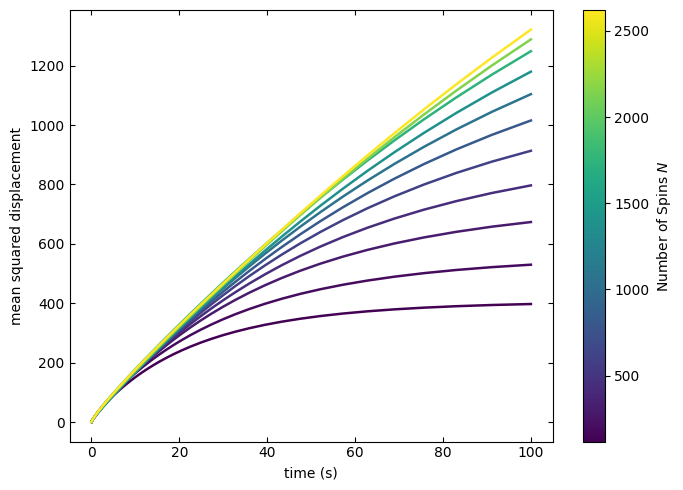

In [50]:
sizes = range(5,15+1)
concentration = 1.1e-2

def get_labels(size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)

    return num_C

labels = {}

for size in sizes:
    num_C = get_labels(size, concentration, 30e-6)
    labels[size] = str(num_C)
    
# Store time and MSD data
results = {}

for size in sizes:
    filename = f"MSD_{round(concentration*1e2,2)}_size{size}_100Itr_PBCv2.npz"
    data = np.load(filename)
    
    time = data["time"]
    msd = data["msd"]
    msd_avg = np.mean(msd, axis=0)  
    
    results[size] = (time, msd_avg)

# # Plotting
# plt.figure()
# for size in sizes:
#     time, msd_avg = results[size]
#     plt.plot(time, msd_avg, label=labels[size])

# plt.tick_params(direction='in')  # for both x and y
# plt.tick_params(top=True, right=True)
# plt.xlabel('time (s)')
# plt.ylabel('mean squared displacement')
# plt.legend(title='Number of Spins N')
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,5))
ax = plt.gca()

# Convert spin number labels (strings) to integers
N_values = np.array([int(labels[size]) for size in sizes])

# Create normalization for colormap
norm = mcolors.Normalize(vmin=N_values.min(), vmax=N_values.max())
cmap = cm.viridis

# Plot each curve with a color corresponding to its spin number
for size, N in zip(sizes, N_values):
    time, msd_avg = results[size]
    color = cmap(norm(N))
    ax.plot(time, msd_avg, color=color, lw=1.8)

# Axis formatting
ax.tick_params(direction='in', top=True, right=True)
ax.set_xlabel('time (s)')
ax.set_ylabel('mean squared displacement')

# Add colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Spins $N$')

plt.tight_layout()

# plt.savefig("C:\\Users\\Suber\\Desktop\\MSD_vs_time_colorbarNv2.eps", format='eps', dpi=300)  

plt.show()

117 spins: alpha = 0.8656931546026863 D = 3.9564470205963316
193 spins: alpha = 0.833044146182703 D = 4.01987653042101
297 spins: alpha = 0.8602625640764265 D = 3.982216175489267
432 spins: alpha = 0.851366872409513 D = 3.834499673715072
603 spins: alpha = 0.8367204034349901 D = 3.8876695393267564
814 spins: alpha = 0.8323646090805874 D = 3.843636571611775
1070 spins: alpha = 0.8410165471766156 D = 3.922949221360003
1375 spins: alpha = 0.8402935713683377 D = 3.6564553984128794
1732 spins: alpha = 0.8473943299767392 D = 4.09319536910023
2146 spins: alpha = 0.8369339300327066 D = 4.100757609819234
2621 spins: alpha = 0.8486933607452218 D = 4.10426489624492


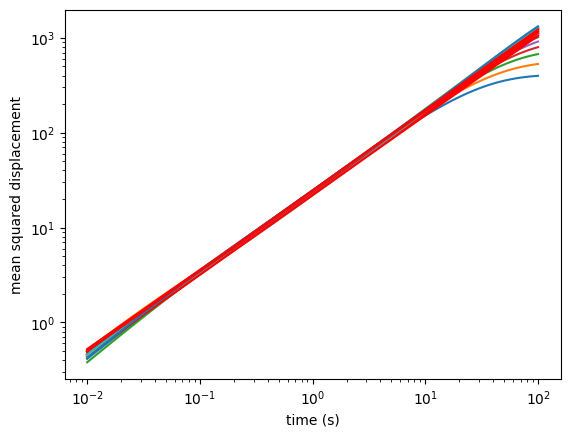

In [29]:
def find_cutoff_index(msd, threshold):
    max_msd = np.max(msd)
    for i in range(len(msd)):
        if msd[i] > threshold * max_msd:
            return i
    return len(msd)

def diffusion_fit(t, alpha, D):
    return 6*D * t**alpha


fit_results = {}

for size in sizes:
    time, msd_avg = results[size]
    
#     min_threshold = 0.001 * np.max(msd_avg)
#     i_start = np.argmax(msd_avg > min_threshold)
    i_start = 1
    i_end = find_cutoff_index(msd_avg, 0.03)
    
    time_fit = time[i_start:i_end]
    msd_fit = msd_avg[i_start:i_end]
    
    if len(time_fit) >= 3:  # minimum points for reliable fit
        popt, pcov = curve_fit(diffusion_fit, time_fit, msd_fit, p0=[1, 1])
        alpha, D = popt
        fit_results[size] = (alpha, D)
    else:
        fit_results[size] = (np.nan, np.nan)  # or skip
        
    
plt.figure()
for size in sizes:
    time, msd_avg = results[size]
    alpha, D = fit_results[size]
    print(labels[size], 'spins: alpha =', alpha, 'D =', D)
    plt.loglog(time, msd_avg, label=labels[size])
    plt.loglog(time, 6*D * time**alpha, color='r')
    
# plt.ylim([0.001, 10])
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
# plt.legend()
plt.show()

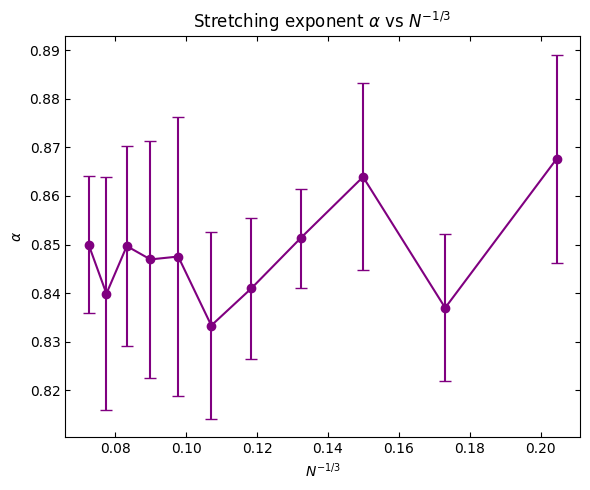

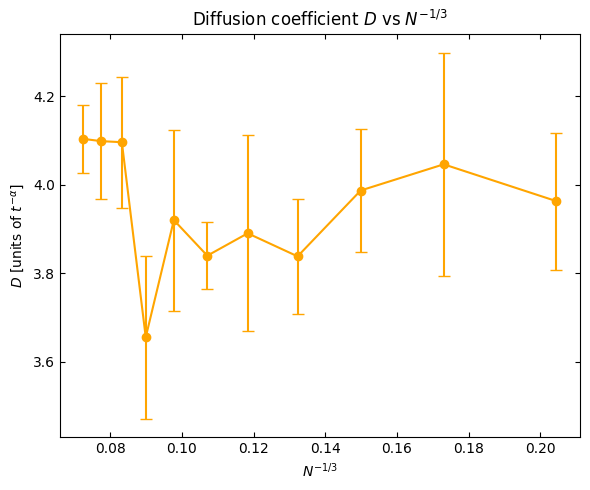


Summary:
Size= 5, N=117, α=0.850±0.014, D=4.104e+00±7.667e-02
Size= 6, N=193, α=0.840±0.024, D=4.098e+00±1.314e-01
Size= 7, N=297, α=0.850±0.021, D=4.096e+00±1.475e-01
Size= 8, N=432, α=0.847±0.024, D=3.656e+00±1.838e-01
Size= 9, N=603, α=0.848±0.029, D=3.920e+00±2.044e-01
Size=10, N=814, α=0.833±0.019, D=3.840e+00±7.515e-02
Size=11, N=1070, α=0.841±0.014, D=3.890e+00±2.214e-01
Size=12, N=1375, α=0.851±0.010, D=3.838e+00±1.304e-01
Size=13, N=1732, α=0.864±0.019, D=3.987e+00±1.385e-01
Size=14, N=2146, α=0.837±0.015, D=4.046e+00±2.519e-01
Size=15, N=2621, α=0.868±0.021, D=3.963e+00±1.549e-01

=== Overall Averages Across Sizes ===
α (mean ± std) = 0.8480 ± 0.0105
D (mean ± std) = 3.9490e+00 ± 1.3906e-01


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob
import re
import os

# ------------------ Helper functions ------------------

def find_cutoff_index(msd, threshold=0.03):
    """Find index where MSD reaches threshold * max(MSD)."""
    max_msd = np.max(msd)
    for i in range(len(msd)):
        if msd[i] > threshold * max_msd:
            return i
    return len(msd)

def diffusion_fit(t, alpha, D):
    """Subdiffusive diffusion law: MSD = 6 D t^alpha."""
    return 6 * D * t**alpha

def get_labels(size, prob_C, prob_e):
    """Compute number of 13C spins for labeling."""
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)
    return num_C

# ------------------ Parameters ------------------

sizes = range(5, 16)
concentration = 1.1e-2   # 1.1%
prob_e = 30e-6
iterations = 100
bin_size = 20
num_bins = iterations // bin_size  # should be 5

# ------------------ Storage ------------------

labels = {size: str(get_labels(size, concentration, prob_e)) for size in sizes}
alpha_mean = []
alpha_err = []
D_mean = []
D_err = []
size_vals = []

# ------------------ Main loop ------------------

for size in sizes:
    filename = f"MSD_{round(concentration*1e2,2)}_size{size}_100Itr_PBCv2.npz"
    if not os.path.exists(filename):
        print(f"Skipping size {size}: file not found")
        continue

    data = np.load(filename)
    T = data["time"]
    msd_all = data["msd"]  # shape (100, len(T))
    assert msd_all.shape[0] == iterations, f"Expected {iterations} iterations for size {size}"

    alpha_batch = []
    D_batch = []

    for b in range(num_bins):
        batch = msd_all[b*bin_size:(b+1)*bin_size]
        msd_avg = np.mean(batch, axis=0)

        i_start = 1
        i_end = find_cutoff_index(msd_avg, threshold=0.03)

        time_fit = T[i_start:i_end]
        msd_fit = msd_avg[i_start:i_end]

        try:
            popt, _ = curve_fit(diffusion_fit, time_fit, msd_fit, p0=[1, 1])
            alpha, D = popt
            alpha_batch.append(alpha)
            D_batch.append(D)
        except RuntimeError:
            print(f"Fit failed for batch {b+1} (size={size})")
            alpha_batch.append(np.nan)
            D_batch.append(np.nan)

    # Convert and clean
    alpha_batch = np.array(alpha_batch)
    D_batch = np.array(D_batch)
    alpha_batch = alpha_batch[~np.isnan(alpha_batch)]
    D_batch = D_batch[~np.isnan(D_batch)]

    if len(alpha_batch) == 0:
        print(f"No valid fits for size {size}, skipping")
        continue

    # Average and SEM
    alpha_mean.append(np.mean(alpha_batch))
    alpha_err.append(np.std(alpha_batch, ddof=1) / np.sqrt(num_bins))
    D_mean.append(np.mean(D_batch))
    D_err.append(np.std(D_batch, ddof=1) / np.sqrt(num_bins))
    size_vals.append(size)

# ------------------ Postprocessing ------------------

size_vals = np.array(size_vals)
alpha_mean = np.array(alpha_mean)
alpha_err = np.array(alpha_err)
D_mean = np.array(D_mean)
D_err = np.array(D_err)

# Convert size → N^(-1/3)
N_vals = np.array([int(labels[s]) for s in size_vals], dtype=float)
Ninv13 = N_vals**(-1/3)

# Sort for clean plotting
order = np.argsort(Ninv13)
Ninv13 = Ninv13[order]
alpha_mean = alpha_mean[order]
alpha_err = alpha_err[order]
D_mean = D_mean[order]
D_err = D_err[order]

# ------------------ Plot α vs N^(-1/3) ------------------

fig = plt.figure(figsize=(6,5))
plt.errorbar(Ninv13, alpha_mean, yerr=alpha_err, fmt='o-', capsize=4, color='purple')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel(r'$N^{-1/3}$')
plt.ylabel(r'$\alpha$')
plt.title(r'Stretching exponent $\alpha$ vs $N^{-1/3}$')
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\alpha_scaling.eps", format='eps', dpi=300)

# ------------------ Plot D vs N^(-1/3) ------------------

fig = plt.figure(figsize=(6,5))
plt.errorbar(Ninv13, D_mean, yerr=D_err, fmt='o-', capsize=4, color='orange')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel(r'$N^{-1/3}$')
plt.ylabel(r'$D$ [units of $t^{-\alpha}$]')
plt.title(r'Diffusion coefficient $D$ vs $N^{-1/3}$')
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\D_scaling.eps", format='eps', dpi=300)

# ------------------ Print summary ------------------

print("\nSummary:")
for i, s in enumerate(size_vals):
    print(f"Size={s:2d}, N={int(labels[s])}, α={alpha_mean[i]:.3f}±{alpha_err[i]:.3f}, D={D_mean[i]:.3e}±{D_err[i]:.3e}")

# ------------------ Overall averages across all sizes ------------------

alpha_all_mean = np.mean(alpha_mean)
alpha_all_std = np.std(alpha_mean, ddof=1)
D_all_mean = np.mean(D_mean)
D_all_std = np.std(D_mean, ddof=1)

print("\n=== Overall Averages Across Sizes ===")
print(f"α (mean ± std) = {alpha_all_mean:.4f} ± {alpha_all_std:.4f}")
print(f"D (mean ± std) = {D_all_mean:.4e} ± {D_all_std:.4e}")


(50, 100)
32538.730257987976


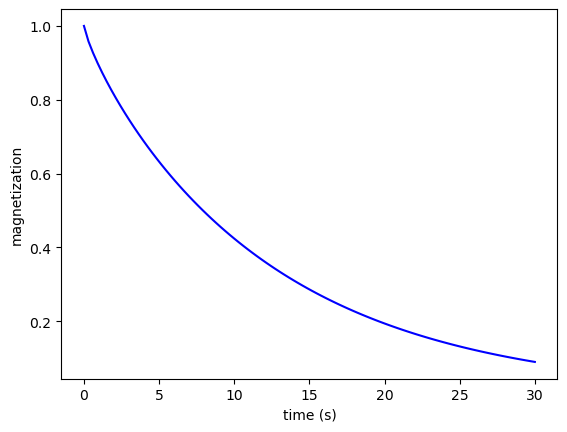

In [2]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts


    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
    #         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    #         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
    #                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)

                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
    #                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,30,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = sample_special_positions(3.57, size, 12.5e-2, 30e-6)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 50
inputs = [(1.75e-8, 2.5e-5)] * iterations

pool = Pool(nodes=2)
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,30,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

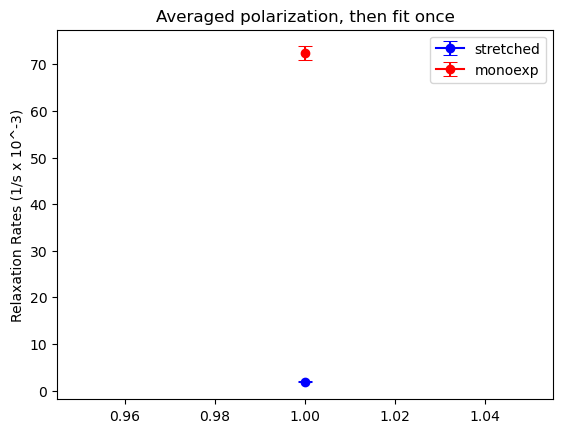

stretched rate = 1.8410133654903043 \pm 0.11433318247294696
mono rate = 72.40369257988746 \pm 1.4255637375544474


In [3]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"12.5%_RelaxationRates_PBC.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

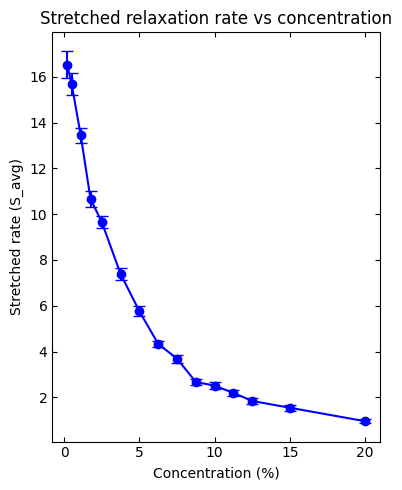

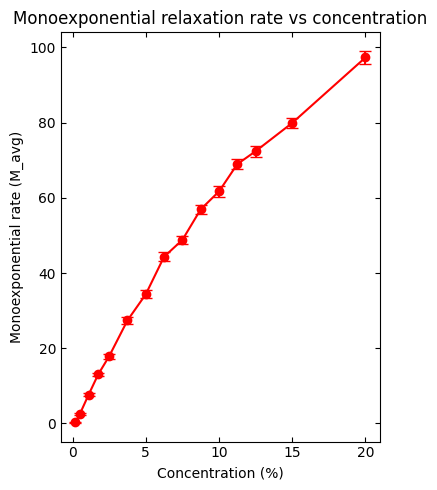

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os

# Scan for all matching files
file_list = sorted(glob.glob("*_RelaxationRates_PBC.npz"))

# Containers
concentrations = []
S_avgs = []
S_errors = []
M_avgs = []
M_errors = []

for file in file_list:
    # Extract concentration from filename (e.g. '0.2%_RelaxationRates.npz')
    match = re.match(r"([0-9.]+)%_RelaxationRates_PBC\.npz", os.path.basename(file))
    if not match:
        continue
    conc = float(match.group(1))

    # Load data
    data = np.load(file)
    S = data["S"]
    M = data["M"]
    S_avg = data["S_avg"]
    M_avg = data["M_avg"]

    # Compute number of iterations
    iterations = len(S)
    S_error = np.sqrt(np.var(S, ddof=1) / iterations)
    M_error = np.sqrt(np.var(M, ddof=1) / iterations)

    # Store
    concentrations.append(conc)
    S_avgs.append(S_avg)
    S_errors.append(S_error)
    M_avgs.append(M_avg)
    M_errors.append(M_error)

# Convert to arrays and sort by concentration
concentrations = np.array(concentrations)
S_avgs = np.array(S_avgs)
S_errors = np.array(S_errors)
M_avgs = np.array(M_avgs)
M_errors = np.array(M_errors)

sort_idx = np.argsort(concentrations)
concentrations = concentrations[sort_idx]
S_avgs = S_avgs[sort_idx]
S_errors = S_errors[sort_idx]
M_avgs = M_avgs[sort_idx]
M_errors = M_errors[sort_idx]

# Plot S_avg vs concentration
fig = plt.figure(figsize=(4,5))
plt.errorbar(concentrations, S_avgs, yerr=S_errors, color='blue', fmt='o-', capsize=4)
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('Concentration (%)')
plt.ylabel('Stretched rate (S_avg)')
plt.title('Stretched relaxation rate vs concentration')
# plt.grid(True)
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\RpVsConc.eps", format='eps', dpi=300)

# Plot M_avg vs concentration
fig = plt.figure(figsize=(4,5))
plt.errorbar(concentrations, M_avgs, yerr=M_errors, color='red', fmt='o-', capsize=4)
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('Concentration (%)')
plt.ylabel('Monoexponential rate (M_avg)')
plt.title('Monoexponential relaxation rate vs concentration')
# plt.grid(True)
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\RdVsConc.eps", format='eps', dpi=300)

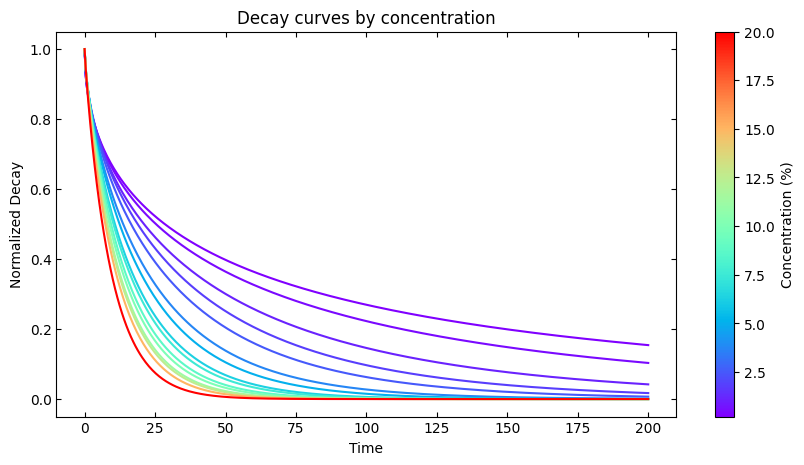

In [60]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a common time array (adjust as needed)
t = np.linspace(0, 200, 500)  # Adjust 10 to cover your decay time range

norm = mcolors.Normalize(vmin=np.min(concentrations), vmax=np.max(concentrations))
cmap = cm.rainbow  # You can change to 'plasma', 'inferno', etc.

# Plot all decay curves
fig, ax = plt.subplots(figsize=(10,5))
for i in range(len(concentrations)):
    S = S_avgs[i] / 1000
    M = M_avgs[i] / 1000
    decay = np.exp(-np.sqrt(S * t)) * np.exp(-M * t)
    
    color = cmap(norm(concentrations[i]))
    label = f"{concentrations[i]:.2f}%"
    ax.plot(t, decay, label=label, color=color)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Concentration (%)")

ax.set_xlabel("Time")
ax.set_ylabel("Normalized Decay")
ax.set_title("Decay curves by concentration")
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\PolVsTimeDifferentConc.eps", format='eps', dpi=300)